## Segmentation

픽셀 수준에서 이미지의 각 부분이 어떤 의미를 갖는 영역인지 분리해 내는 방법
- semantic segmentation
- instance segmentation

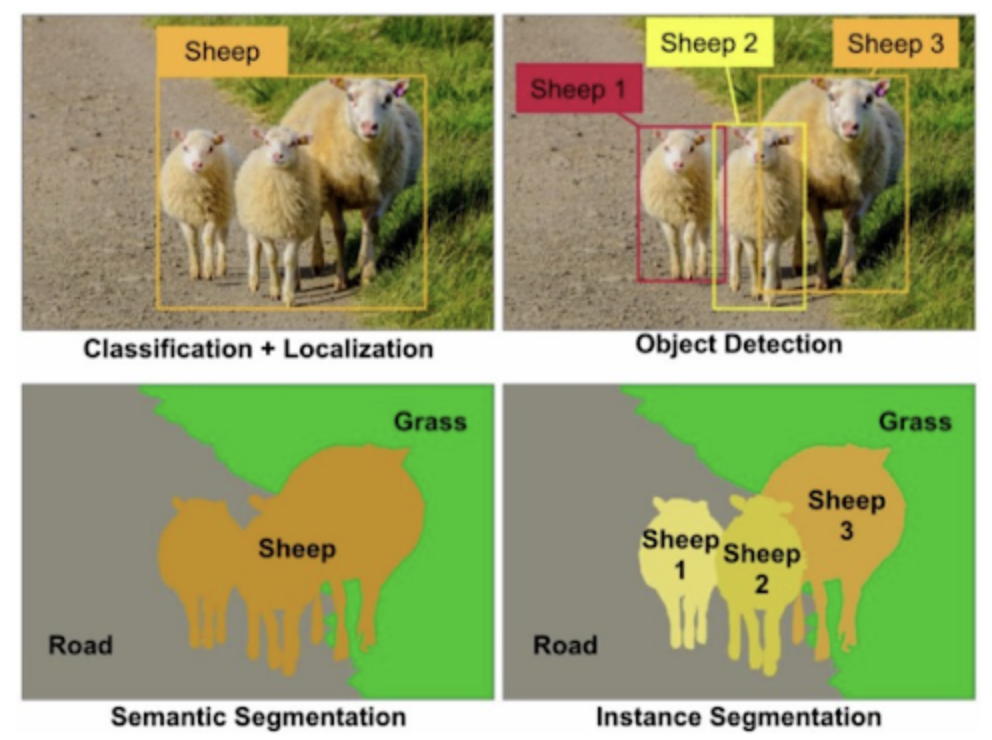

In [3]:
from IPython.display import Image
Image(filename='capture/computer_vision.png', width=600) 

### semantic segmentation 대표적인 모델

#### U-Net

- input: 572 x 572 x 1
- output: 388 x 388 x 2
  - output 에 채널이 2개인 이유는, 각각 해당 클래스에 대한 segmentation map 을 가리키고 있기 때문이다.
  - 예를 들어) 인물이면 - 인물/배경, 비정상세포검출이면 - 비정상/정상

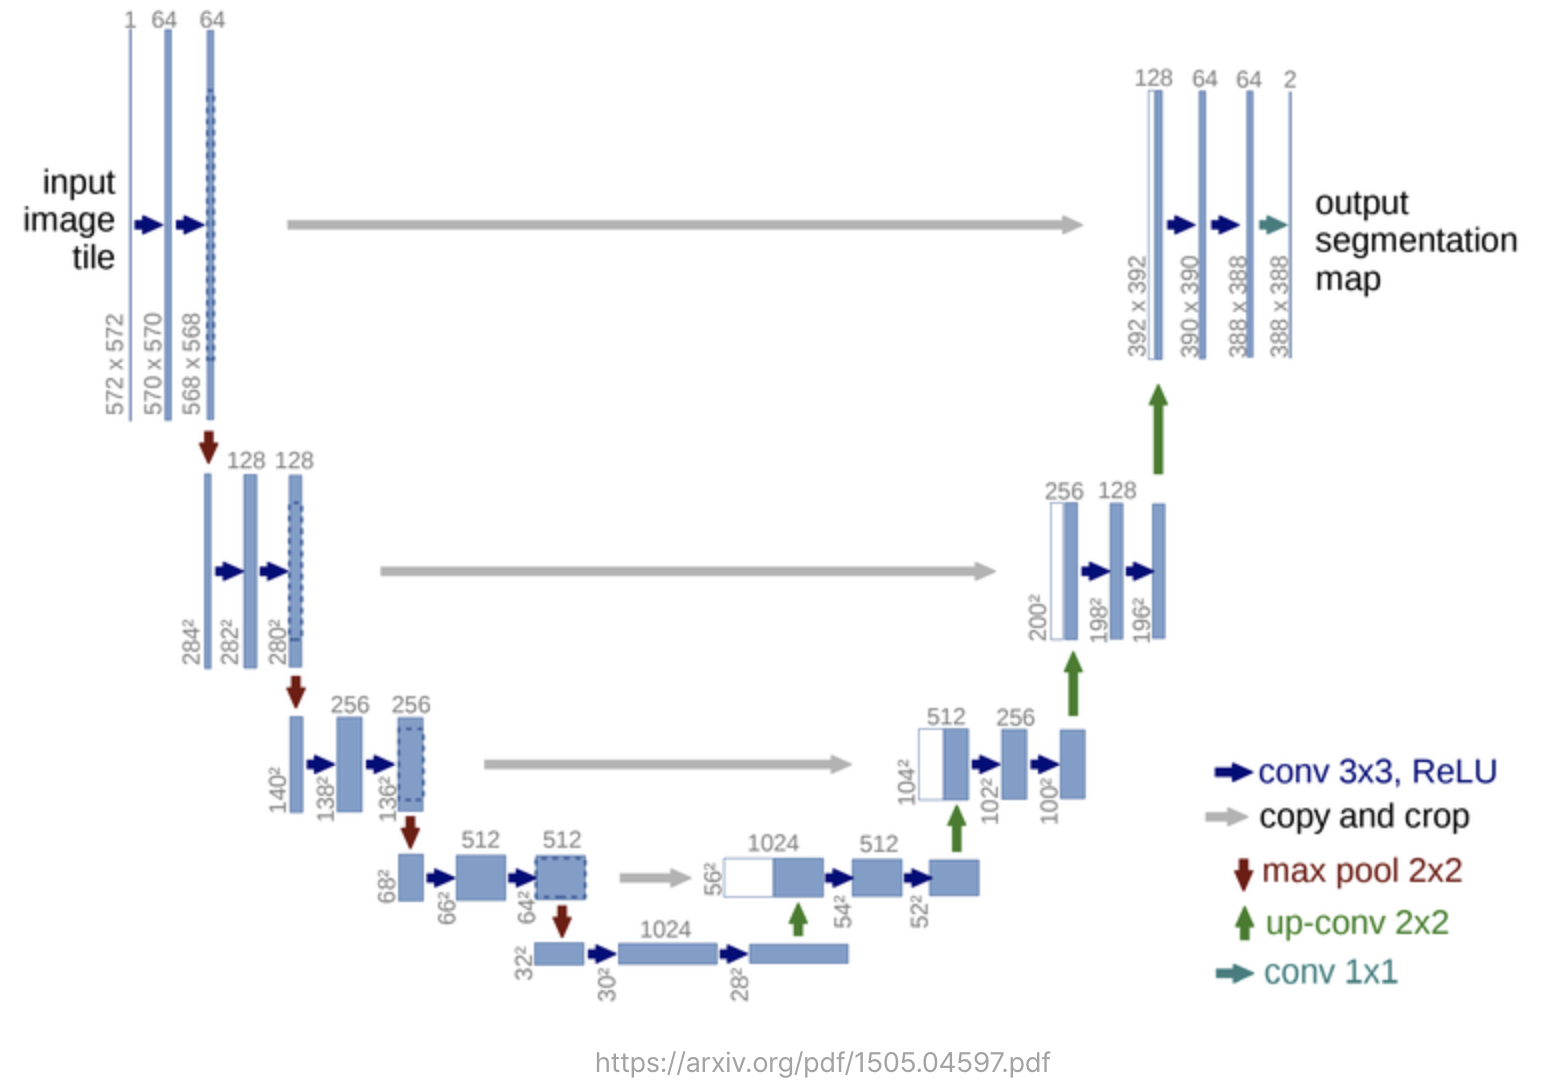

In [7]:
from IPython.display import Image
Image(filename='capture/unet.png', width=700) 

### instance segmentation 대표적인 모델

물체 검출(object detection) 모델로 각 개체를 구분하고   
이후에 각 개체 별로 시맨틱 세그멘테이션을 수행하면 인스턴스 세그멘테이션을 할 수 있지 않을까?

#### Mask-RCNN

- Faster-R-CNN의 아이디어인 Region of Interest Pooling Layer(RoIPool) 개념을 개선하여  
  정확한 Segmentation에 유리하게 한 RoIAlign
- 그리고 클래스별 마스크 분리

이렇게 단순한 두 가지 아이디어를 통해,  
클래스별 Object Detection과 시멘틱 세그멘테이션을 사실상 하나의 Task로 엮어낸 것으로 평가받는 중요한 모델

참고로, RoIPool 은?
- 다양한 RoI 영역을 Pooling을 통해 동일한 크기의 Feature map으로 추출해 내는 레이어
- 이후 이 고정 사이즈의 Feature map을 바탕으로 바운딩 박스와 object의 클래스를 추론
- 단점
  - 이미지에서 RoI 영역의 크기는 다양한데, 모든 RoI 영역의 가로/세로 픽셀 크기가 16의 배수인 것은 아니다.
  - 아래 그림의 예에서 가로 200, 세로 145픽셀짜리 RoI 영역을 16X16으로 분할된 영역 중 절반 이상이 RoI 영역에 덮이는 곳들로 끼워 맞추다 보면
  - 어쩔 수 없이 RoI 영역 밖이 포함되는 경우도 있고, 자투리 영역이 버려지는 경우도 생기게 된다.
  - ===> RoIPool 과정에서 Quantization이 필요하다!
  - ===> 이런 상황은 필연적으로 시맨틱 세그멘테이션의 정보손실과 왜곡을 야기하게 됨

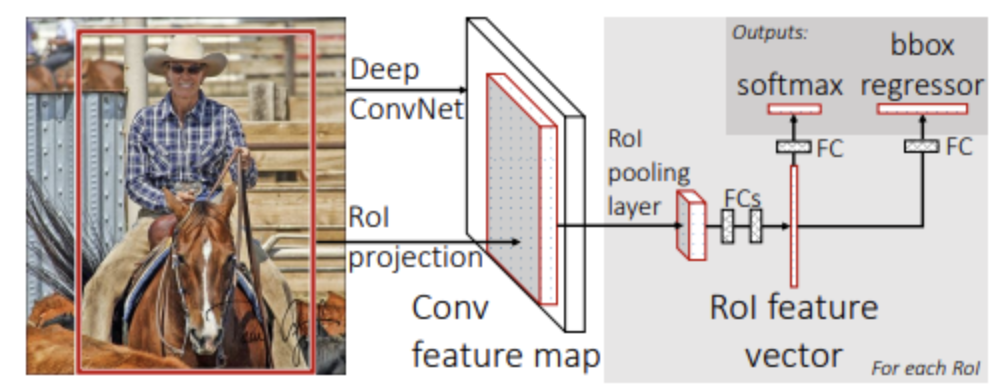

In [11]:
from IPython.display import Image
Image(filename='capture/roi_pooling.png', width=700) 

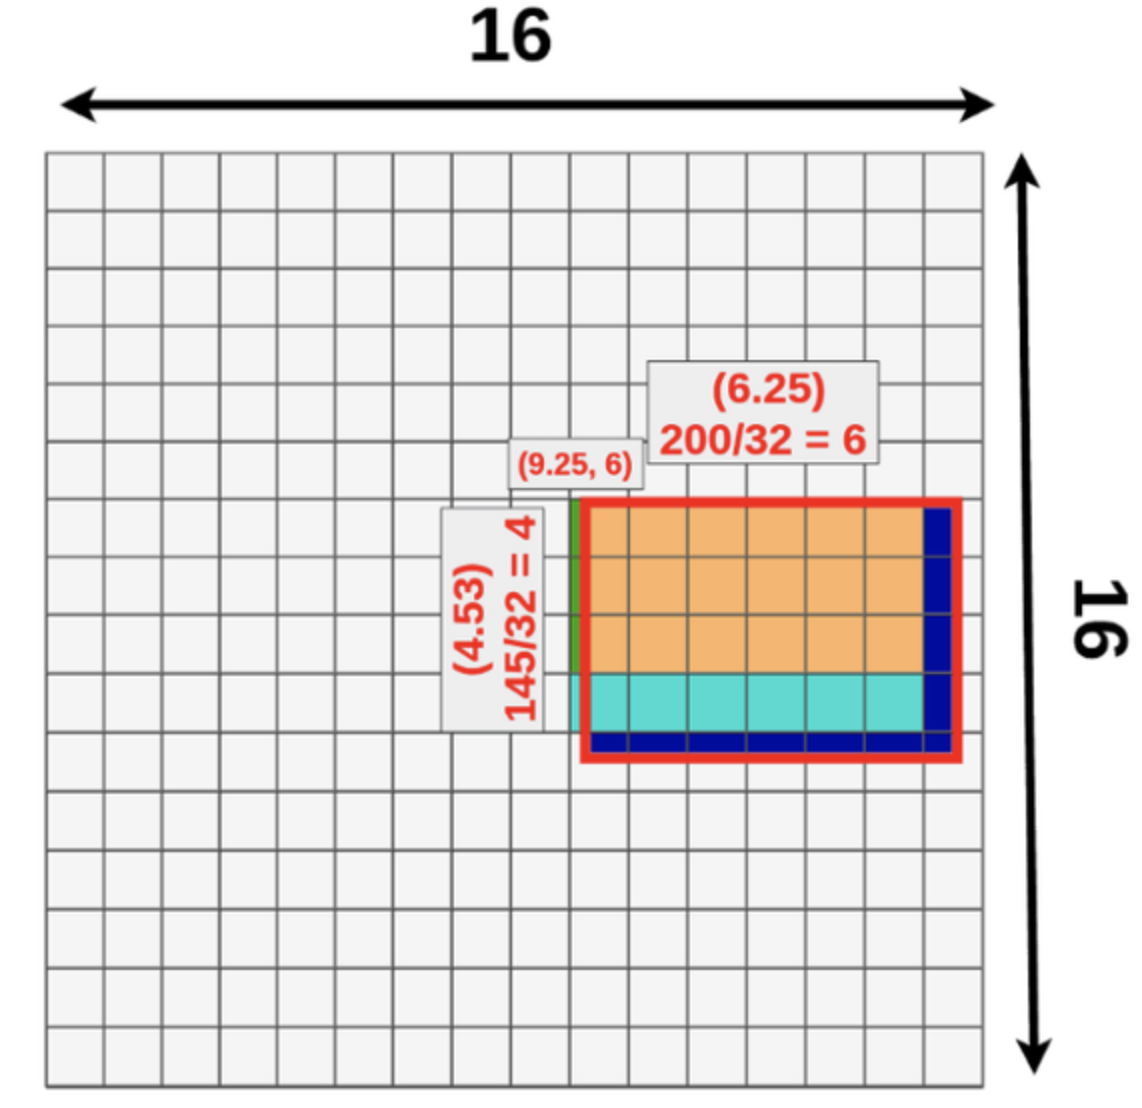

In [13]:
from IPython.display import Image
Image(filename='capture/roi_pooling_losses_in_quantization.png', width=400) 

- 예) 위 그림에서, 가로 200, 세로 145의 RoI 영역에 대해 3X3의 RoIPool 을 적용할 경우
  - RoI Pooling 은 가로/세로 각각 3의 배수만 가능
  - 그러므로 6 x 3 영역
  - 그러므로 녹색 영역은 불필요하게 포함, 파랑/민트 영역은 정보를 잃어버리게 되는 영역

Mask-R-CNN의 RoIAlign은 Quantization하지 않고도 RoI를 처리할 고정 사이즈의 Feature map을 생성할 수 있게 아이디어를 제공
- RoI 영역을 pooling layer의 크기에 맞추어 등분한 후, 
- RoIPool을 했을 때의 quantization 영역 중 가까운 것들과의 bilinear interpolation 계산을 통해 생성해야 할 Feature Map을 계산해 낸다는 점

Mask R-CNN 은 Faster R-CNN 에서 특성 추출방식을 "RoIAlign" 방식으로 개선을 하고 세그멘테이션을 더한 방식
- 아래 Faster R-CNN과 비교한 구조도를 보면 
  - U-Net처럼 피처 맵(feature map)의 크기를 키워 마스크(mask)를 생성해 내는 부분을 통해 인스턴스에 해당하는 영역, 즉 인스턴스 맵을 추론

Mask R-CNN은 클래스에 따른 마스크를 예측할 때, 여러 가지 태스크를 한 모델로 학습하여 물체 검출의 성능을 높인다.

아래 그림을 보면 Bounding box regression을 하는 Bbox head와 마스크를 예측하는 Mask Head의 두 갈래로 나뉘는 것을 볼 수 있음
- Mask map의 경우 시맨틱 세그멘테이션과 달리 상대적으로 작은 28x28의 특성 맵 크기를 갖는다.
- RoIAlign을 통해 줄어든 특성에서 마스크를 예측하기 때문에 사용하려는 목적에 따라서 정확한 마스크를 얻으려는 경우에는 부적합할 수 있다.

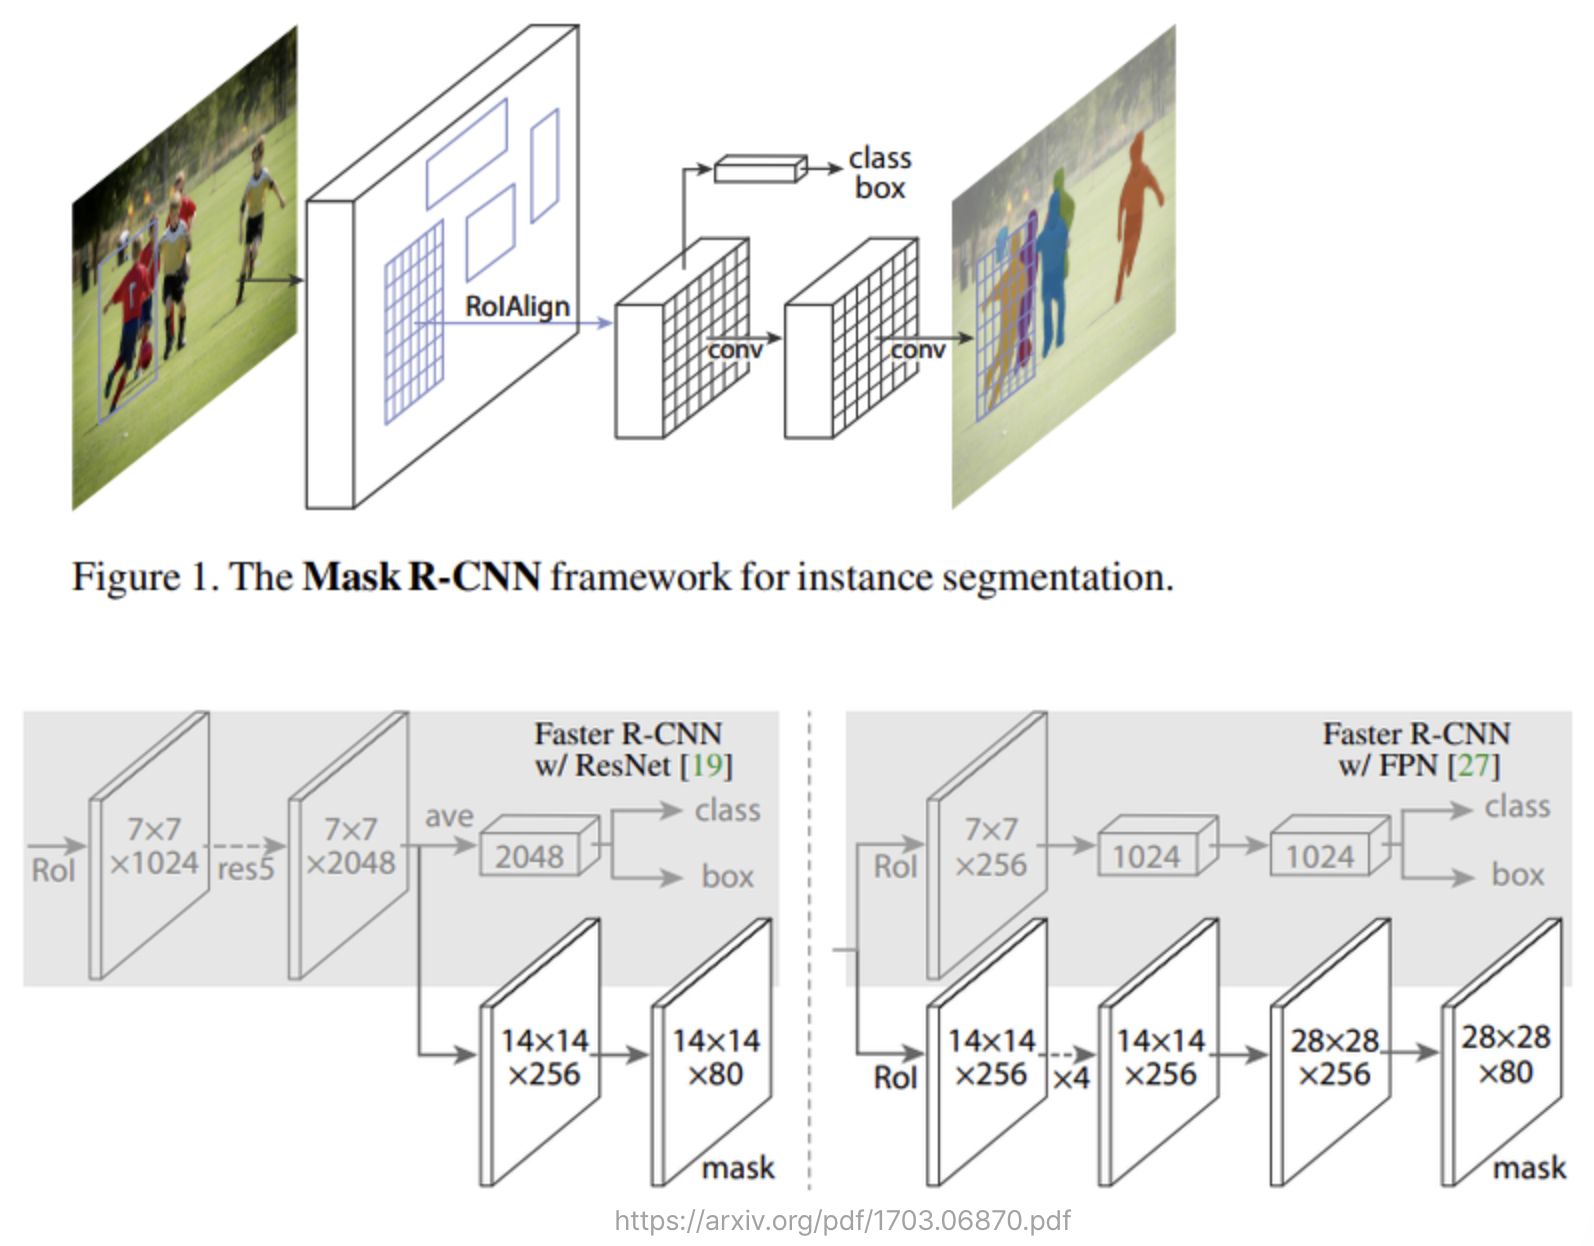

In [16]:
from IPython.display import Image
Image(filename='capture/mask_rcnn.png', width=600) 

### 주요 segmentation model

1) FCN(Fully Convolutional Network)
- fully connected layer 대신 CNN 적용
- Skip Architecture 적용
- https://youtu.be/_52dopGu3Cw 참고
- Skip Architecture 를 위해서는 Upsampling 을 사용함
  - FCN에서는 Deconvolution과 Interpolation 방식을 활용합
    - Deconvolution은 컨볼루션 연산을 거꾸로 해준 것이라고 볼 수 있.
    - Interpolation은 보간법으로 주어진 값들을 통해 추정해야 하는 픽셀의 값을 추정하는 것
      - Linear interpolation 과 Bilinear interpolation
      - Linear interpolation: 두 점의 값이 주어졌을 때 그 사이에 위치한 값을 직선 거리에 따른 선형적으로 계산
      - Bilinear interpolation: 1차원의 linear interpolation 을 2차원으로 확장한 것

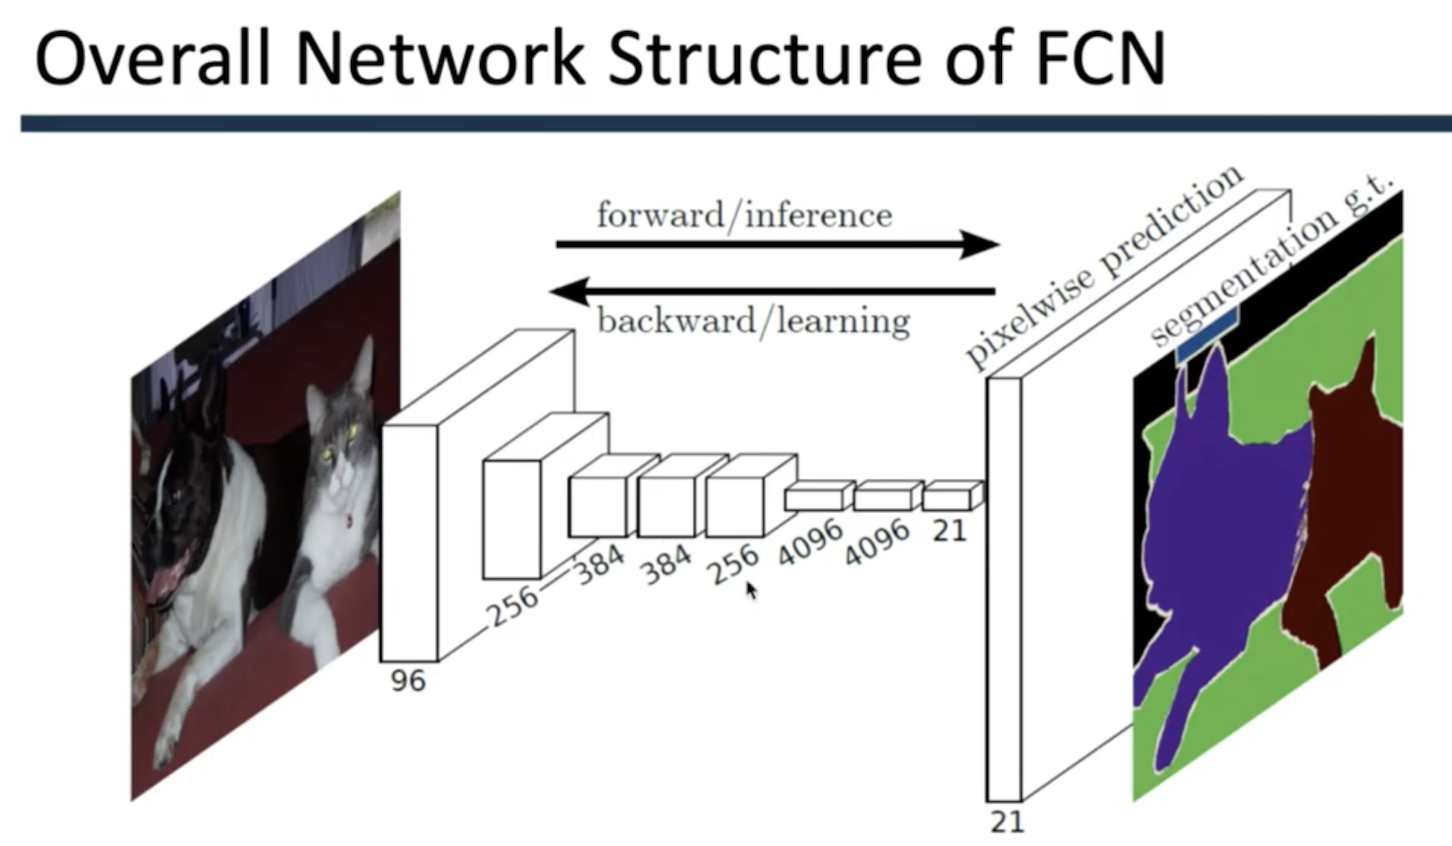

In [17]:
from IPython.display import Image
Image(filename='capture/fcn.png', width=600) 

2) U-Net
- FCN에서 upsampling을 통해서 특성 맵을 키운 것을 입력값과 대칭적으로 만들어 준 것
- skip connection처럼 연결해 주어 low-level의 feature를 활용할 수 있도록 함
- 마지막에는 1x1 convolution으로 원하는 시맨틱 세그멘테이션 맵을 얻을 수 있음
- 결과적으로는, 입력으로 572x572 크기인 이미지가 들어가고 출력으로 388x388의 크기에 두 가지의 클래스를 가진 세그멘테이션 맵이 나옴
- https://youtu.be/evPZI9B2LvQ 참고

- U-Net 에서는 데이터 불균형 해결을 위해 weighted map 을 학습 때 사용함
  - 세포를 검출해 내기 위해서는 세포들의 영역뿐만 아니라 경계 또한 예측을 해야 한다.
  - 이때 픽셀 단위로 라벨을 매긴다고 생각하면, 데이터셋에 세포나 배경보다는 절대적으로 세포 간 경계의 면적이 작을 것이다.
  - 이러한 클래스 간 데이터 양의 불균형을 해결해 주기 위해서 분포를 고려한 weight map을 학습 때 사용했다.
- 여기서 weight map의 weight는
  - 신경망의 학습 파라미터를 가리키는 weight 가 아님.
  - 손실 함수(loss)에 적용되는 가중치를 말함
- 의료 영상에서 세포 내부나 배경보다는 상대적으로 면적이 작은 세포 경계를 명확하게 추론해 내는 것이 더욱 중요하기 때문에, 세포 경계의 손실에 더 많은 페널티를 부과하는 방식

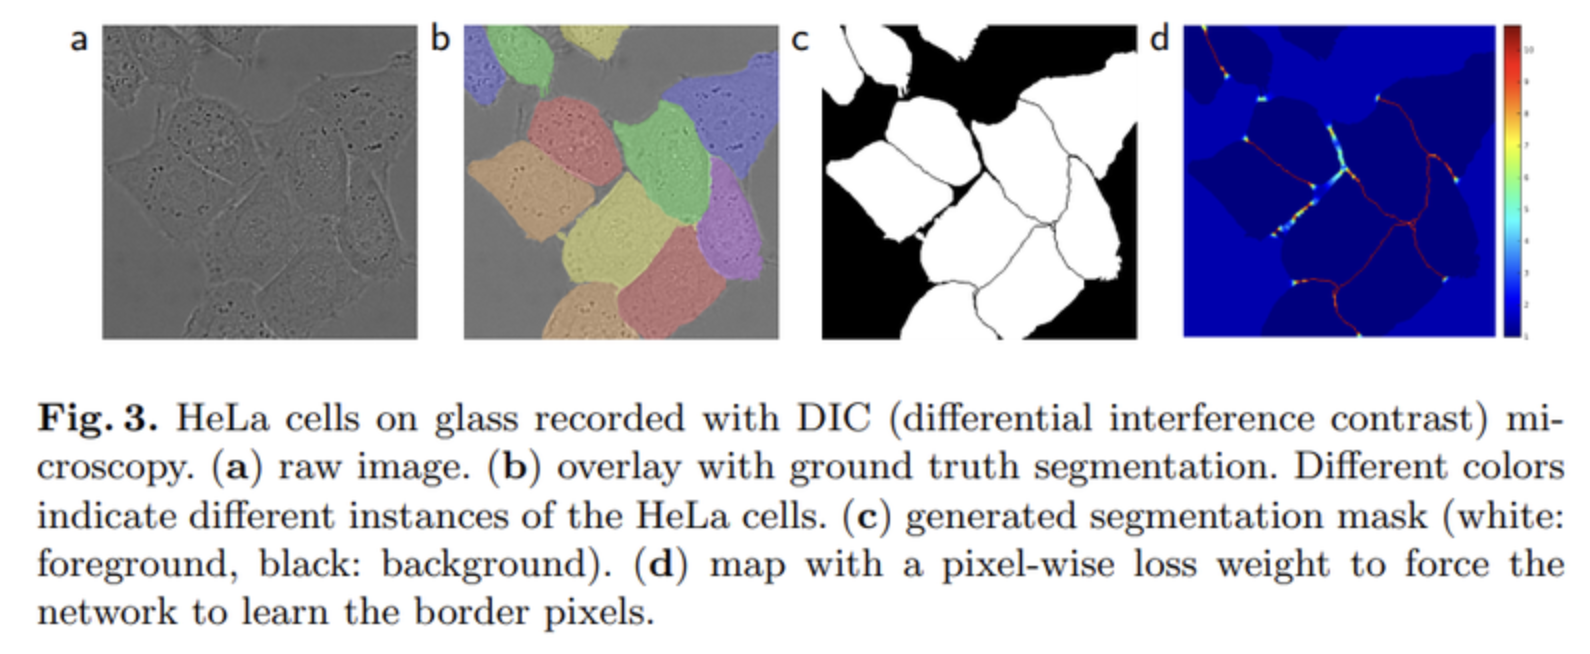

In [18]:
from IPython.display import Image
Image(filename='capture/unet_data_imbalance.png', width=600) 

3) DeepLab 계열
- DeppLab+3 까지 개선을 거쳐온 모델
- https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/ 참고
- https://youtu.be/JiC78rUF4iI 참고
- DeepLabv3+의 전체 구조를 본 뒤 Dilated Convolution이라고도 불리는 Atrous Convolution과 Spatial Pyramid Pooling을 살펴보자.

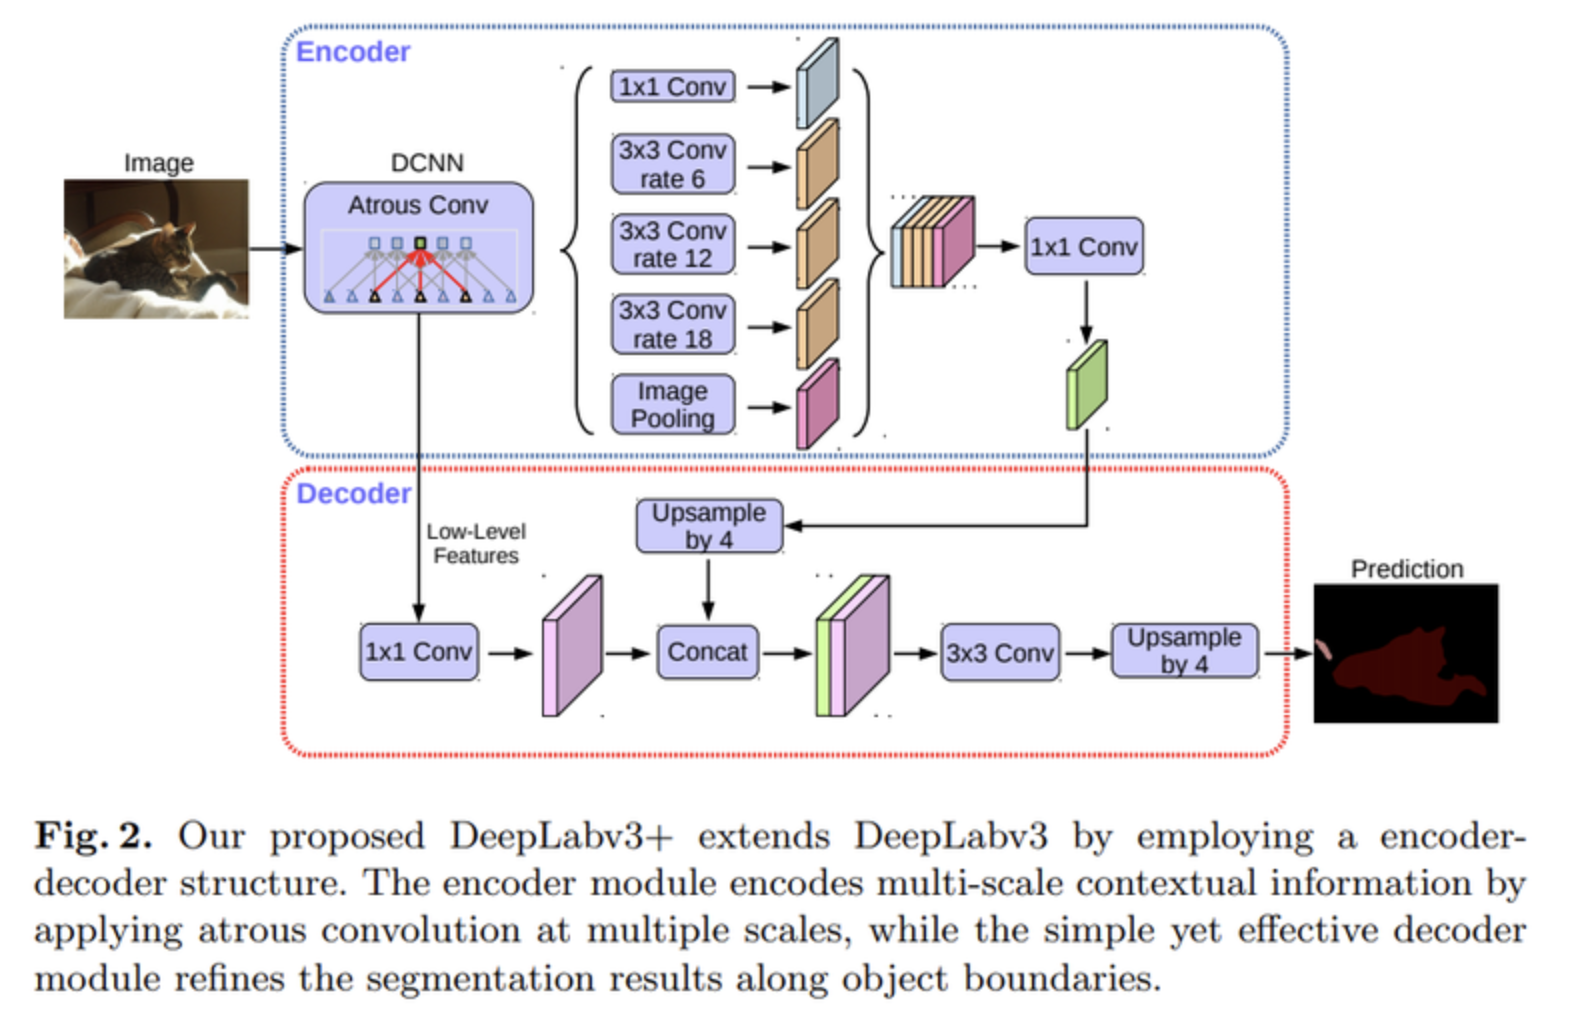

In [19]:
from IPython.display import Image
Image(filename='capture/deeplabv3+.png', width=600) 

- U-Net 의 Contracting path과 Expansive path의 역할을 하는 것이 여기서는 위 그림의 인코더(Encoder), 디코더(Decoder) 이다.
- U-Net 과 달리 DeepLabV3+ 는 Atrous Convolution을 사용하고 있다.
- Atrous Convolution을 여러 크기에 다양하게 적용한 것이 ASPP(Atrous Spatial Pyramid Pooling)

3-1) Atronos Convolution
- 띄엄 띄엄 보는 컨볼루션
- 일반적인 컨볼루션과 달리 더 넓은 영역을 보도록 해주기 위한 방법으로 커널이 일정 간격으로 떨어져 있다. 
- 이를 통해 컨볼루션 레이어를 너무 깊게 쌓지 않아도 넓은 영역의 정보를 커버할 수 있게 된다.

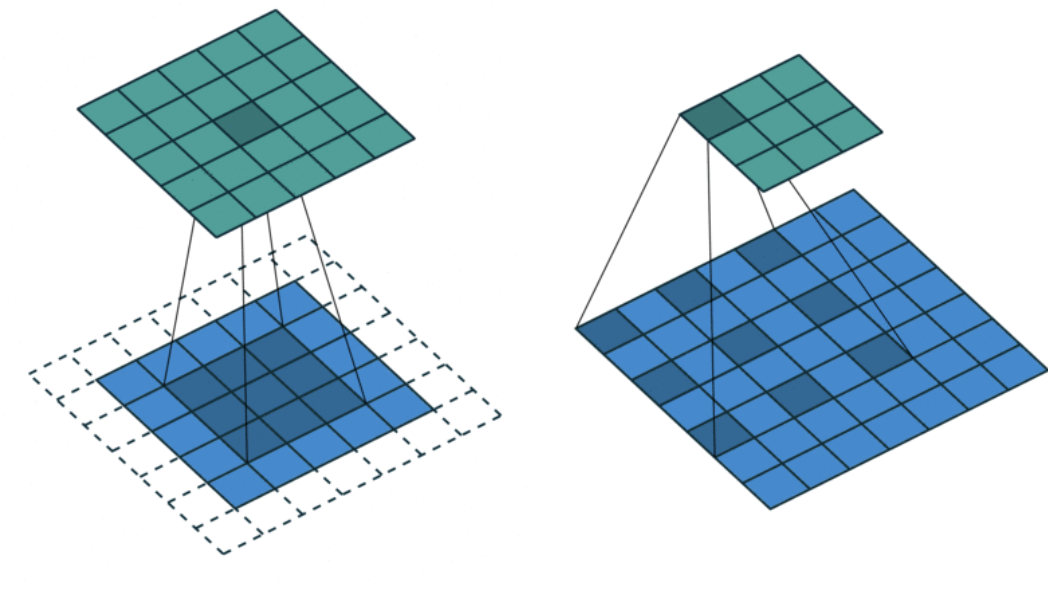

In [24]:
from IPython.display import Image
Image(filename='capture/atrous_convolution.png', width=600) 

3-2) Spatial Pyramid Pooling
- 여러 가지 스케일로 convolution과 pooling을 하고 나온 다양한 특성을 연결(concatenate)
- 이를 통해서 멀티스케일로 특성을 추출하는 것을 병렬로 수행하는 효과를 얻을 수 있다. 
- 여기서 컨볼루션을 Atrous Convolution으로 바꾸어 적용한 것은 Atrous Spatial Pyramid Pooling

이러한 아키텍쳐는 입력 이미지의 크기와 관계없이 동일한 구조를 활용할 수 있다는 장점이 있다.  
그러므로 제각기 다양한 크기와 비율을 가진 RoI 영역에 대해 적용하기에 유리하다.

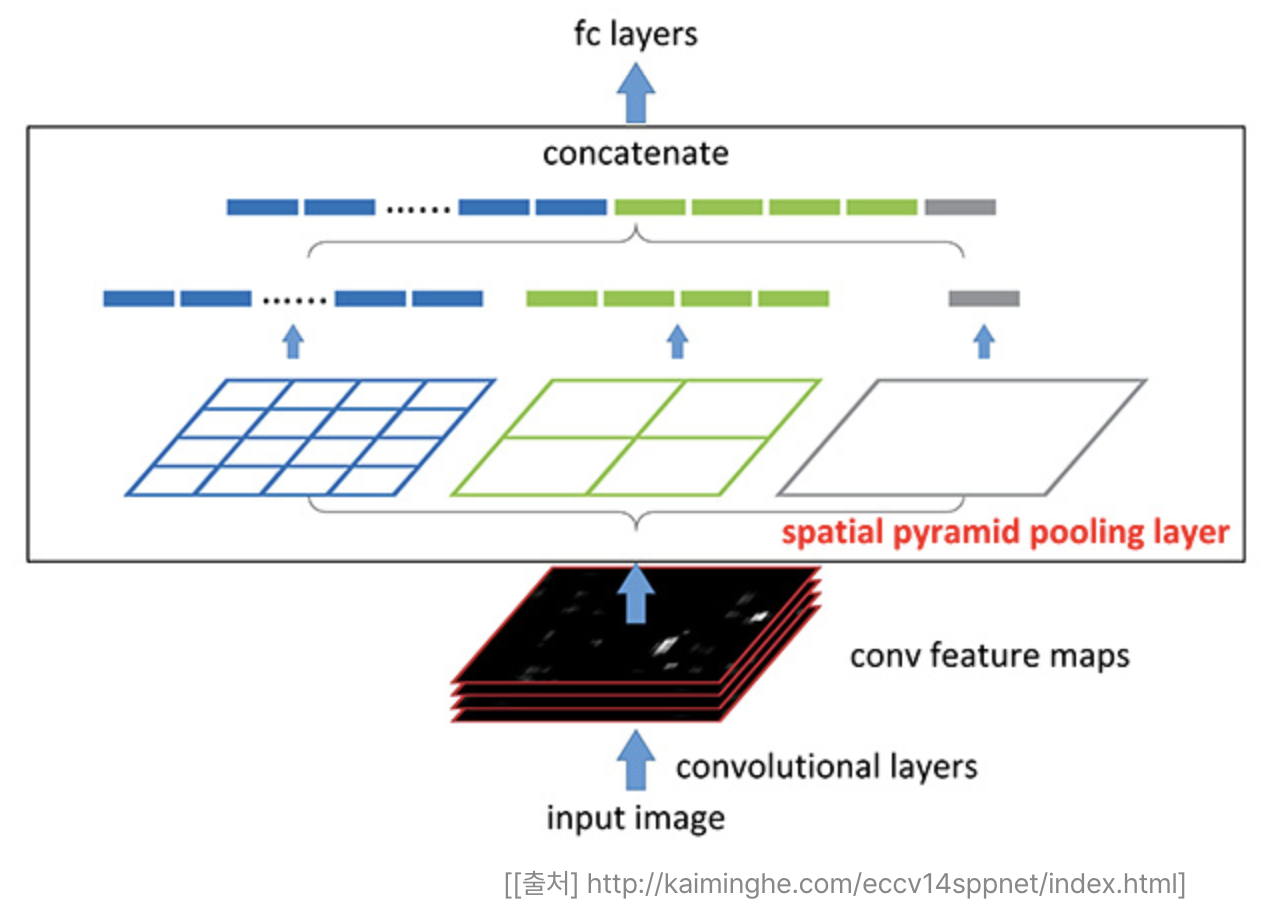

In [25]:
from IPython.display import Image
Image(filename='capture/spatial_pyramid_pooling.png', width=600) 

### Segmentation 평가

일반적으로 시맨틱 세그멘테이션의 결괏값은 이미지의 크기에 맞는 세그멘테이션 맵 크기 와 시맨틱 클래스의 수에 맞는 채널 크기 를 갖는다.

여기서 각 채널의 max probability에 따라서 해당 위치의 클래스가 결정된다.

1) 픽셀 별 정확도 (pixel accuracy)
- 픽셀에 따른 정확도를 의미

2) Mask IoU
- 마스크 IoU를 클래스 별로 계산하면 한 이미지에서 여러 클래스에 대한 IoU 점수를 얻을 수 있다. 
- 이를 평균하면 전체적인 시맨틱 세그멘테이션 성능을 가늠할 수 있다.
- 계산하는 코드는 생각보다 간단하다.

// sample for mask iou  
intersection = np.logical_and(target, prediction)  
union = np.logical_or(target, prediction)  
iou_score = np.sum(intersection) / np.sum(union)

### Upsampling 의 다양한 기법

Segementation에서는 마스킹 단계에 Upsampling이 중요하게 사용되었다는 것을 알 수 있다.

upsampling 하는 주요 방법은?

1) Nearest Neightor
- 원본에서 가장 가까운 값을 그대로 사용

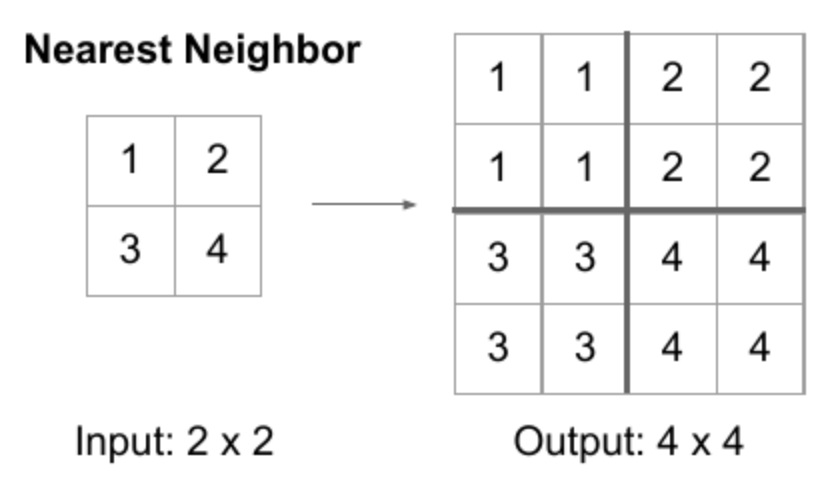

In [29]:
from IPython.display import Image
Image(filename='capture/nearest_neighbor.png', width=400) 

2) Bilinear Interpolation
- 두 축에 대해서 선형보간법을 통해 필요한 값을 메우는 방식

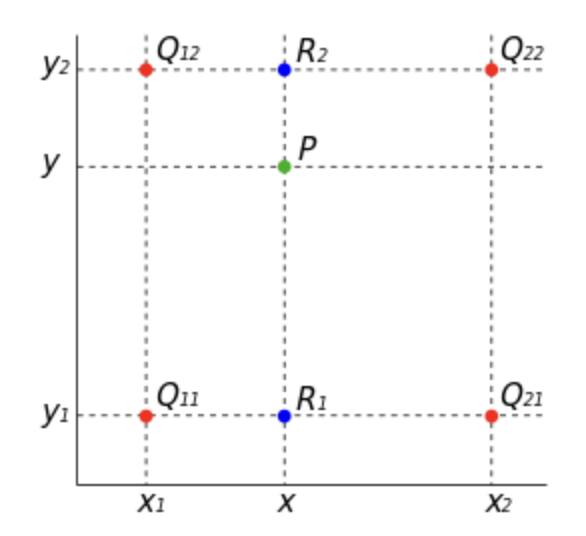

In [31]:
from IPython.display import Image
Image(filename='capture/bilinear_interpolation.png', width=400) 

3) Transposed Convolution
- 거꾸로 학습된 파라미터로 입력된 벡터를 통해 더 넓은 영역의 값을 추정
- https://zzsza.github.io/data/2018/06/25/upsampling-with-transposed-convolution/ 참고

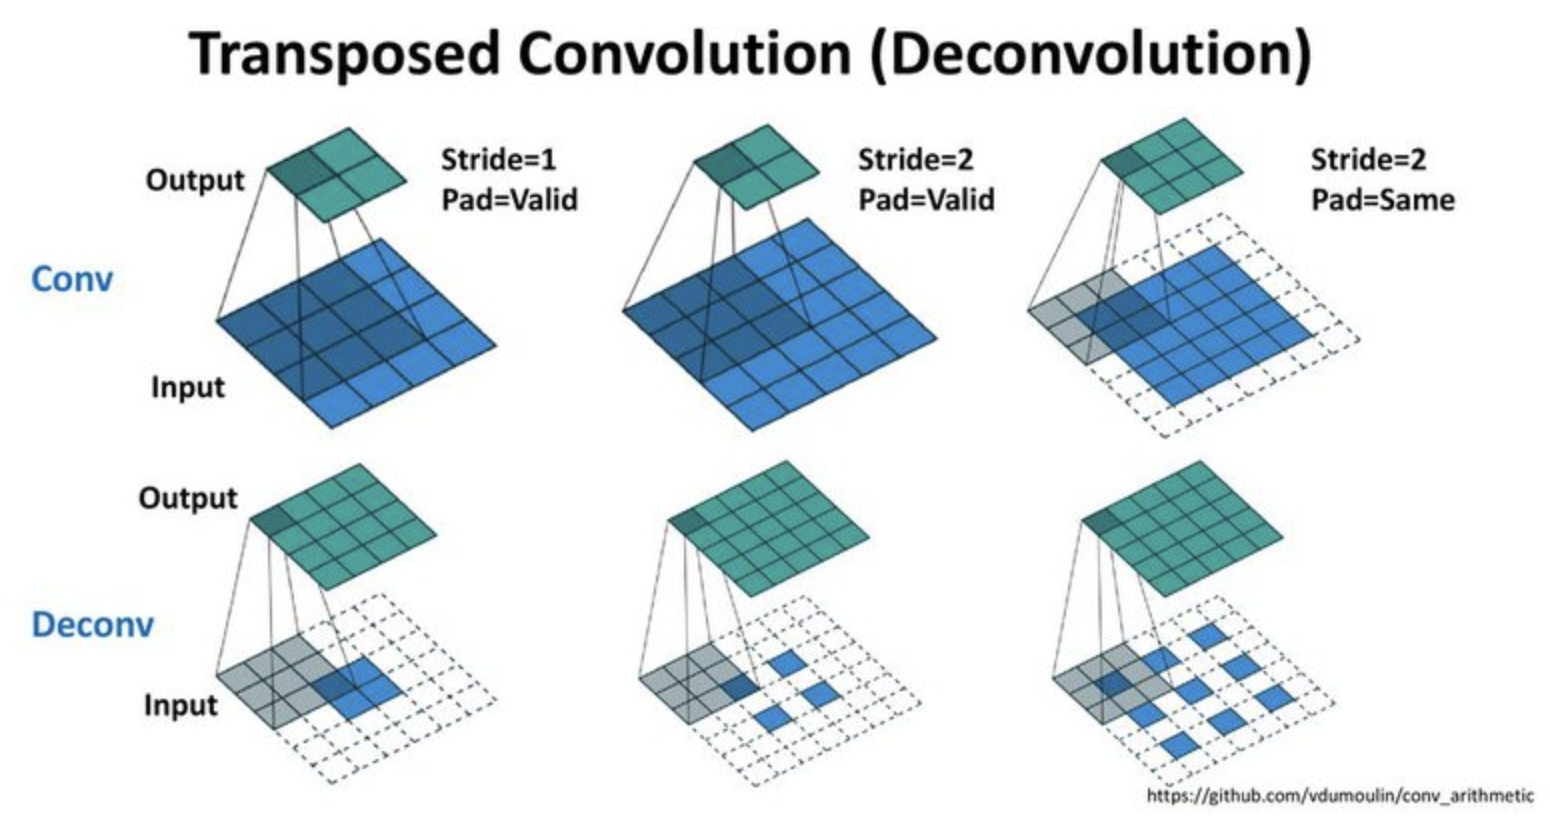

In [32]:
from IPython.display import Image
Image(filename='capture/transposed_convolution.png', width=600) 